# make figure summarizing phytoplankton changes

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint','SSH','IFRAC_DJFmean','NPP_sp','NPP_diat']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint
spC_zint
zooC_zint
SSH
IFRAC_DJFmean
NPP_sp
NPP_diat
CPU times: user 448 ms, sys: 36.2 ms, total: 484 ms
Wall time: 1.03 s


In [3]:
ds['mesozooC'] = ds.zooC_zint * (ds.diatC_zint/(ds.diatC_zint + ds.spC_zint))
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

### Necessary plotting function

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [5]:
grid = pop_tools.get_grid('POP_gx1v6')

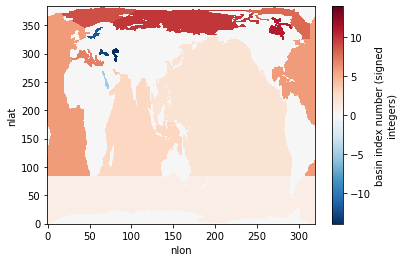

In [6]:
grid.REGION_MASK.plot()

In [7]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [8]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [9]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [10]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [11]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [12]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [13]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [14]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [15]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

### Read in masks

In [16]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

In [17]:
diat_frac_change = ensemble_mean_2090s.diat_frac - ensemble_mean_1920s.diat_frac

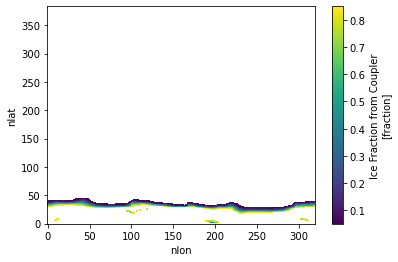

In [18]:
ds_masks.marginal_SIZ_mask.plot()

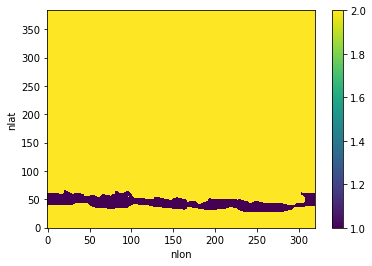

In [19]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

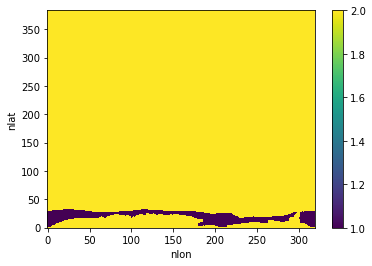

In [20]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

In [21]:
SIZ = SIZ.where(grid.REGION_MASK>0)

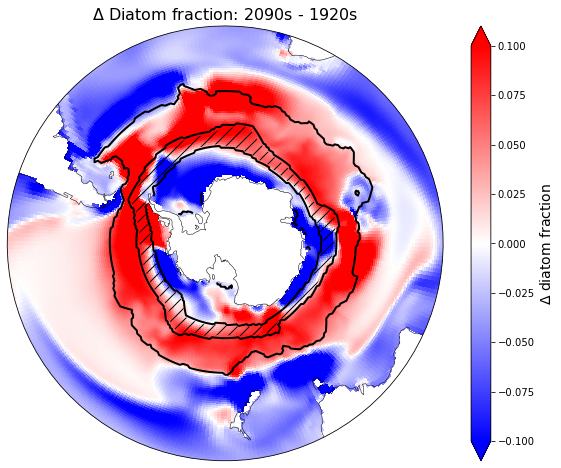

In [22]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Diatom fraction: 2090s - 1920s',fontsize=16)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

############ masks ################################

## IFRAC
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)
# sh = lat[:, 0] < 0
# lon = lon[sh, :]
# lat = lat[sh, :]
# field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = adjust_pop_grid(lons, lats, ACC)
# sh = lat[:, 0] < 0
# lon = lon[sh, :]
# lat = lat[sh, :]
# field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
# fmt = {}
# strs = ['${\sigma}_{\Theta}$26.4','${\sigma}_{\Theta}$26.9']
# for l, s in zip(pci.levels, strs):
#     fmt[l] = s
# ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')
cbar1.set_label(label='${\Delta}$ diatom fraction', fontsize=14)
#fig.savefig('/glade/work/kristenk/figs/diatfracchange_withmasks.png', bbox_inches='tight', dpi=300, format='png');

#### do zonal means

In [23]:
zonal_1920s = ds_1920s.isel(nlat=slice(0,93)).mean(dim='nlon').compute()
zonal_1990s = ds_1990s.isel(nlat=slice(0,93)).mean(dim='nlon').compute()
zonal_2090s = ds_2090s.isel(nlat=slice(0,93)).mean(dim='nlon').compute()

In [24]:
zonal_1920s_ens_mean = ensemble_mean_1920s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_1990s_ens_mean = ensemble_mean_1990s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_2090s_ens_mean = ensemble_mean_2090s.isel(nlat=slice(0,93)).mean(dim='nlon')
lats_zonal = lats.isel(nlat=slice(0,93)).mean(dim='nlon')

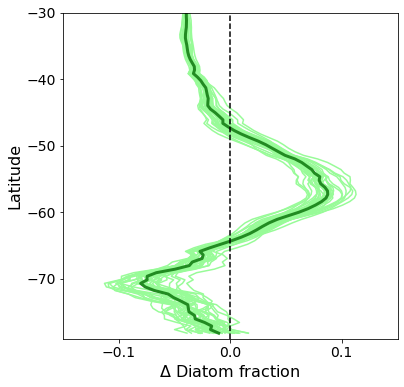

In [25]:
fig = plt.figure(figsize=(6,6))

### diat frac
ax = fig.add_subplot(1,1,1)

ax.set_ylim(-79,-30)
ax.set_xlim(-0.15,0.15)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
#ax.plot(zonal_1990s['diat_frac']-zonal_1920s['diat_frac'],lats_zonal,  label='1990s', linewidth=3)

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.diat_frac.isel(member_id=mem) - zonal_1920s.diat_frac.isel(member_id=mem), 
         lats_zonal, 
         color='palegreen')
    
ax.plot(zonal_2090s_ens_mean['diat_frac']-zonal_1920s_ens_mean['diat_frac'],lats_zonal,  label='2090s', linewidth=3, color='forestgreen')

    
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ Diatom fraction',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)
#fig.savefig('/glade/work/kristenk/figs/zonal_changes_diatfrac.png', bbox_inches='tight', dpi=300, format='png');

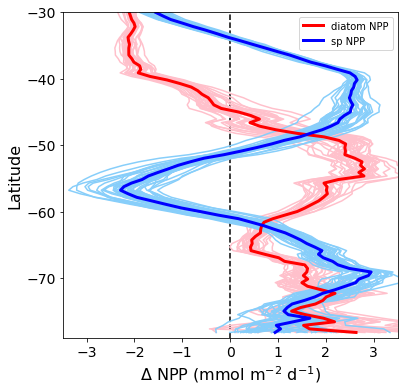

In [26]:
fig = plt.figure(figsize=(6,6))

convert_rate = 0.01 * 86400  #converting from mmol/m^3/s cm to mmol/m2/d

### NPP
ax = fig.add_subplot(1,1,1)

ax.set_ylim(-79,-30)
ax.set_xlim(-3.5,3.5)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.NPP_diat.isel(member_id=mem)*convert_rate - zonal_1920s.NPP_diat.isel(member_id=mem)*convert_rate, 
         lats_zonal, 
         color='pink')
    
for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.NPP_sp.isel(member_id=mem)*convert_rate - zonal_1920s.NPP_sp.isel(member_id=mem)*convert_rate, 
         lats_zonal, 
         color='lightskyblue')


ax.plot(zonal_2090s_ens_mean['NPP_diat']*convert_rate-zonal_1920s_ens_mean['NPP_diat']*convert_rate,lats_zonal,  label='diatom NPP', linewidth=3,color='red')
ax.plot(zonal_2090s_ens_mean['NPP_sp']*convert_rate-zonal_1920s_ens_mean['NPP_sp']*convert_rate,lats_zonal,  label='sp NPP', linewidth=3,color='blue')
ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ NPP (mmol m$^{-2}$ d$^{-1}$)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
#plt.locator_params(axis='x', nbins=4)
#fig.savefig('/glade/work/kristenk/figs/zonal_changes_diatfrac.png', bbox_inches='tight', dpi=300, format='png');

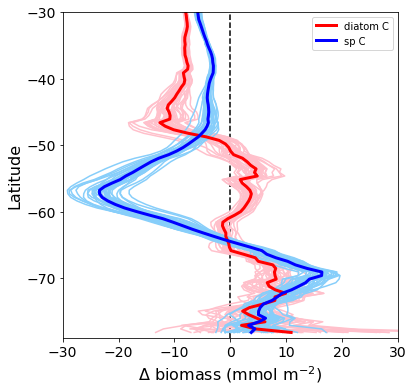

In [27]:
fig = plt.figure(figsize=(6,6))

### biomass
ax = fig.add_subplot(1,1,1)

ax.set_ylim(-79,-30)
ax.set_xlim(-30,30)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.diatC_zint.isel(member_id=mem) - zonal_1920s.diatC_zint.isel(member_id=mem), 
         lats_zonal, 
         color='pink')
    
for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.spC_zint.isel(member_id=mem) - zonal_1920s.spC_zint.isel(member_id=mem), 
         lats_zonal, 
         color='lightskyblue')


ax.plot(zonal_2090s_ens_mean['diatC_zint']-zonal_1920s_ens_mean['diatC_zint'],lats_zonal,  label='diatom C', linewidth=3,color='red')
ax.plot(zonal_2090s_ens_mean['spC_zint']-zonal_1920s_ens_mean['spC_zint'],lats_zonal,  label='sp C', linewidth=3,color='blue')
ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ biomass (mmol m$^{-2}$)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
#plt.locator_params(axis='x', nbins=4)
#fig.savefig('/glade/work/kristenk/figs/zonal_changes_diatfrac.png', bbox_inches='tight', dpi=300, format='png');

### put it all together

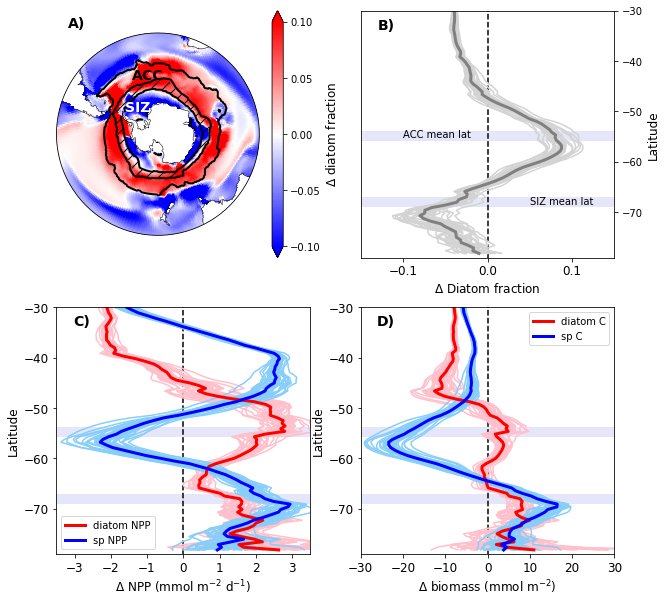

In [28]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('A)',fontsize=14,fontweight='bold',x=0.1,y=1)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### diat frac
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

# ### SIZ
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### hatch marks in marginal sea ice zone 
lon, lat, field = adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',pad=0.05) #orientation='horizontal'
cbar1.set_label(label='${\Delta}$ diatom fraction', fontsize=12)
cbar1.ax.locator_params(nbins=5)

################################################ zonal diat frac
ax = fig.add_subplot(2,2,2)

ax.set_ylim(-79,-30)
ax.set_xlim(-0.15,0.15)
ax.set_title('B)', x=0.1,y=0.9,fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
ax.annotate('ACC mean lat', xy=(-0.1, -55.2))
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax.annotate('SIZ mean lat', xy=(0.05, -68.5))

plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.diat_frac.isel(member_id=mem) - zonal_1920s.diat_frac.isel(member_id=mem), 
         lats_zonal, 
         color='lightgray')
    
ax.plot(zonal_2090s_ens_mean['diat_frac']-zonal_1920s_ens_mean['diat_frac'],lats_zonal,  label='2090s', linewidth=3, color='gray')

    

ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='${\Delta}$ Diatom fraction',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()


convert_rate = 0.01 * 86400  #converting from mmol/m^3/s cm to mmol/m2/d

####################################### NPP
ax = fig.add_subplot(2,2,3)

ax.set_ylim(-79,-30)
ax.set_xlim(-3.5,3.5)
ax.set_title('C)', x=0.1,y=0.9,fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region

plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.NPP_diat.isel(member_id=mem)*convert_rate - zonal_1920s.NPP_diat.isel(member_id=mem)*convert_rate, 
         lats_zonal, 
         color='pink')
    
for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.NPP_sp.isel(member_id=mem)*convert_rate - zonal_1920s.NPP_sp.isel(member_id=mem)*convert_rate, 
         lats_zonal, 
         color='lightskyblue')


ax.plot(zonal_2090s_ens_mean['NPP_diat']*convert_rate-zonal_1920s_ens_mean['NPP_diat']*convert_rate,lats_zonal,  label='diatom NPP', linewidth=3,color='red')
ax.plot(zonal_2090s_ens_mean['NPP_sp']*convert_rate-zonal_1920s_ens_mean['NPP_sp']*convert_rate,lats_zonal,  label='sp NPP', linewidth=3,color='blue')
ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='${\Delta}$ NPP (mmol m$^{-2}$ d$^{-1}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

####################################### biomass
ax = fig.add_subplot(2,2,4)

ax.set_ylim(-79,-30)
ax.set_xlim(-30,30)
ax.set_title('D)', x=0.1,y=0.9, fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.diatC_zint.isel(member_id=mem) - zonal_1920s.diatC_zint.isel(member_id=mem), 
         lats_zonal, 
         color='pink')
    
for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.spC_zint.isel(member_id=mem) - zonal_1920s.spC_zint.isel(member_id=mem), 
         lats_zonal, 
         color='lightskyblue')


ax.plot(zonal_2090s_ens_mean['diatC_zint']-zonal_1920s_ens_mean['diatC_zint'],lats_zonal,  label='diatom C', linewidth=3,color='red')
ax.plot(zonal_2090s_ens_mean['spC_zint']-zonal_1920s_ens_mean['spC_zint'],lats_zonal,  label='sp C', linewidth=3,color='blue')
ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='${\Delta}$ biomass (mmol m$^{-2}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

plt.figtext(0.23, 0.785, 'ACC', fontsize=14,fontweight='bold')
plt.figtext(0.22, 0.74, 'SIZ', fontsize=14, color='white',fontweight='bold');
fig.savefig('/glade/work/kristenk/figs/phytofrac_change_fig.png', bbox_inches='tight', dpi=300, format='png');

### show changes in total biomass & NPP (for SI)

In [29]:
zonal_2090s['phytoC'] = zonal_2090s['spC_zint'] + zonal_2090s['diatC_zint']
zonal_2090s_ens_mean['phytoC'] = zonal_2090s_ens_mean['spC_zint'] + zonal_2090s_ens_mean['diatC_zint']
zonal_2090s['NPP'] = zonal_2090s['NPP_diat'] + zonal_2090s['NPP_sp']
zonal_2090s_ens_mean['NPP'] = zonal_2090s_ens_mean['NPP_diat'] + zonal_2090s_ens_mean['NPP_sp']


zonal_1920s['phytoC'] = zonal_1920s['spC_zint'] + zonal_1920s['diatC_zint']
zonal_1920s_ens_mean['phytoC'] = zonal_1920s_ens_mean['spC_zint'] + zonal_1920s_ens_mean['diatC_zint']
zonal_1920s['NPP'] = zonal_1920s['NPP_diat'] + zonal_1920s['NPP_sp']
zonal_1920s_ens_mean['NPP'] = zonal_1920s_ens_mean['NPP_diat'] + zonal_1920s_ens_mean['NPP_sp']

In [30]:
zonal_1920s_ens_mean

<xarray.Dataset>
Dimensions:     (nlat: 93, z_t: 60)
Dimensions without coordinates: nlat, z_t
Data variables:
    KMT         (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    TAREA       (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    dz          (z_t, nlat) float32 dask.array<chunksize=(60, 93), meta=np.ndarray>
    diatC_zint  (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    spC_zint    (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    zooC_zint   (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    SSH         (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    IFRAC       (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    NPP_sp      (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    NPP_diat    (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    mesozooC    (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    diat_frac   (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    phytoC      (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    NPP         (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>

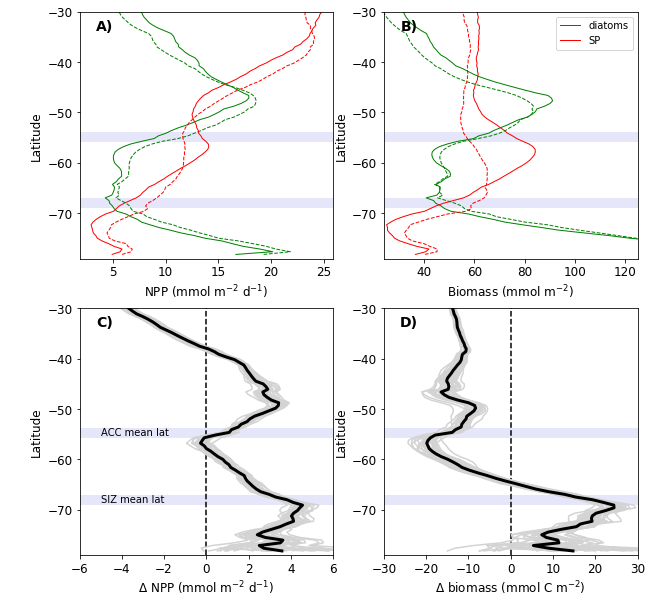

In [32]:
fig = plt.figure(figsize=(10,10))



############################# NPP total


ax = fig.add_subplot(2,2,1)

ax.set_ylim(-79,-30)
#ax.set_xlim(-6,6)
ax.set_title('A)', x=0.1,y=0.9,fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region

plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax.annotate('ACC mean lat', xy=(-5, -55.2))
ax.annotate('SIZ mean lat', xy=(-5, -68.5))

ax.plot(zonal_1920s_ens_mean['NPP_diat']*convert_rate,lats_zonal,  label= 'diatom NPP', linewidth=1,color='green')
ax.plot(zonal_1920s_ens_mean['NPP_sp']*convert_rate,lats_zonal,  label= 'SP NPP', linewidth=1,color='red')


ax.plot(zonal_2090s_ens_mean['NPP_diat']*convert_rate,lats_zonal,linewidth=1,color='green',linestyle='--')
ax.plot(zonal_2090s_ens_mean['NPP_sp']*convert_rate,lats_zonal,linewidth=1,color='red',linestyle='--')

#ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='NPP (mmol m$^{-2}$ d$^{-1}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
############################# biomass total

ax = fig.add_subplot(2,2,2)

ax.set_ylim(-79,-30)
ax.set_xlim(24,125)
ax.set_title('B)', x=0.1,y=0.9,fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region

plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax.annotate('ACC mean lat', xy=(-5, -55.2))
ax.annotate('SIZ mean lat', xy=(-5, -68.5))

ax.plot(zonal_1920s_ens_mean['diatC_zint'],lats_zonal,  label= 'diatoms', linewidth=1,color='green')
ax.plot(zonal_1920s_ens_mean['spC_zint'],lats_zonal,  label= 'SP', linewidth=1,color='red')

ax.plot(zonal_2090s_ens_mean['diatC_zint'],lats_zonal, linewidth=1,color='green',linestyle='--')
ax.plot(zonal_2090s_ens_mean['spC_zint'],lats_zonal, linewidth=1,color='red',linestyle='--')

ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='Biomass (mmol m$^{-2}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);



####################################### NPP change
ax = fig.add_subplot(2,2,3)

ax.set_ylim(-79,-30)
ax.set_xlim(-6,6)
ax.set_title('C)', x=0.1,y=0.9,fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region

plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax.annotate('ACC mean lat', xy=(-5, -55.2))
ax.annotate('SIZ mean lat', xy=(-5, -68.5))

plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.NPP.isel(member_id=mem)*convert_rate - zonal_1920s.NPP.isel(member_id=mem)*convert_rate, 
         lats_zonal, 
         color='lightgray')
    

ax.plot(zonal_2090s_ens_mean['NPP']*convert_rate-zonal_1920s_ens_mean['NPP']*convert_rate,lats_zonal,  label= 'total NPP', linewidth=3,color='black')
#ax.legend()
ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='${\Delta}$ NPP (mmol m$^{-2}$ d$^{-1}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

####################################### biomass change
ax = fig.add_subplot(2,2,4)

ax.set_ylim(-79,-30)
ax.set_xlim(-30,30)
ax.set_title('D)', x=0.1,y=0.9, fontweight='bold',fontsize=14)
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
plt.axvline(x=0,color='black',linestyle='--')

for mem in np.arange(0,34,1):
    ax.plot(zonal_2090s.phytoC.isel(member_id=mem) - zonal_1920s.phytoC.isel(member_id=mem), 
         lats_zonal, 
         color='lightgray')


ax.plot(zonal_2090s_ens_mean['phytoC']-zonal_1920s_ens_mean['phytoC'],lats_zonal,  label='phytoplankton C', linewidth=3,color='black')

ax.set_ylabel(ylabel='Latitude',fontsize=12)
ax.set_xlabel(xlabel='${\Delta}$ biomass (mmol C m$^{-2}$)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

fig.savefig('/glade/work/kristenk/figs/biomass_NPP_change_figSI.png', bbox_inches='tight', dpi=300, format='png');